# Data Wrangling - WeRateDogs project

by Mark Trapani

## Introduction

Data Wrangling is a core practice commonly used by people working with quantative data. This process involves gathering, assessing and cleaning data to ensure that final data can be analysed, visualized and modelled in a more efficient and precise way.

In this project we will gather data related to the _WeRateDogs_ Twitter account from multiple sources and prepare (clean) it to be used for later analysis.

## Gathering Data

First step of the Data Wrangling process involves gathering all required data from different sources:

-  loading the twitter-archive-enhanced.csv file which was manually downloaded and saved in the working file directory
-  programmatically downloading image-predictions.tsv and loading it to our workspace
-  querying Twitter's API to get tweet data using Tweepy

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy
import time
import re
import nltk
import time 
nltk.download('punkt')
import nltk.tag.stanford
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
from datetime import datetime,timedelta
import matplotlib.pyplot as plt



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Loading twitter-archive-enhanced.csv

In [2]:
archive_df = pd.read_csv("twitter-archive-enhanced.csv")
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Downloading and loading image-predictions.tsv

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url, allow_redirects=True)
#open('image-predictions.tsv', 'wb').write(r.content)

In [4]:
image_df = pd.read_csv("image-predictions.tsv",delimiter='\t')
image_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Querying Twitter's API

In [5]:
consumer_key = 'yAVZwUg9nr7Dtr67Uykwt2VEv'
consumer_secret = 'SNIv3nG5QaQ5eygHyLQ4um3mWh1QyPlsveSefzMayHtO0pagz1'

access_token = '389353956-MqLfEPh1im4nIh6v7Othuz5OxZEmMw6b44OntqPR'
access_token_secret = 'hFOp6ovzoIllcnTMQCvhMf3tnVNEKfv3Fk1rToT8yIbrZ'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth,
                 parser = tweepy.parsers.JSONParser(), #Parse to Json Object
                 wait_on_rate_limit = True, #Automatically wait for rate limits to replenish
                 wait_on_rate_limit_notify = True) #Print a notification when Tweepy is waiting for rate limits to replenish


#create 2 lists to store tweet ids and tweets with errors
api_data = []
error_data = []

#start time for below execution
start_time = time.time()

#iterating through the different tweet_ids (from archive_data) to call additional data from the Twitter API
for tweet_id in archive_df['tweet_id']:
    try:
        WeRateDogs_tweets = api.get_status(tweet_id)
        favorites = WeRateDogs_tweets['favorite_count']
        retweets = WeRateDogs_tweets['retweet_count']
        
        api_data.append({'tweet_id': int(tweet_id),
                        'favorites': int(favorites),
                        'retweets': int(retweets)})
    
    except Exception as e:
        print(str(tweet_id)+ " _ " + str(e))
        error_data.append(tweet_id)
        
#print execution time
print("--- %s seconds ---" % (time.time() - start_time))

#Putting API data in a dataframe
json_df = pd.DataFrame(api_data, columns = ['tweet_id', 'favorites', 'retweets'])

#Saving df to tweet_json.txt
json_df.to_csv('tweet_json.txt', index = False)

### Loading tweet_json.txt 

In [6]:
json_df = pd.read_csv('tweet_json.txt')
json_df.head()

,tweet_id,favorites,retweets
0,892420643555336193,38266,8389
1,892177421306343426,32798,6192
2,891815181378084864,24701,4098
3,891689557279858688,41595,8525
4,891327558926688256,39778,9238


## Assessing Data

Assessing data is the second step in data wrangling which basically involves looking out for data quality issues (content issues) and lack of tidiness (structural issues). This process is carried out visually and programmatically.


### Archive Data

#### Visual Observations

In [7]:
#viewing archive_df
archive_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [8]:
#We have 2356 total entries with 17 columns
#sample entry
archive_df.sample()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1405,699323444782047232,NaN,NaN,2016-02-15 20:04:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""I'm bathing the children what do you want?"" ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/699323444...,10,10,None,None,None,None,None


#### Programmatic Assessment

In [9]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [10]:
archive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [11]:
#checking for duplicates
archive_df_copy = archive_df.copy()

archive_df_copy["is_duplicated"] = archive_df_copy['tweet_id'].duplicated()
archive_df_copy.loc[archive_df_copy["is_duplicated"] != False]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,is_duplicated


### Image Data

#### Visual Observations

In [12]:
#viewing image_df
image_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [13]:
#We have 2075 entries and 12 columns
#sample entry
image_df.sample()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1840,837820167694528512,https://pbs.twimg.com/media/C6CI_jbVAAA3-a1.jpg,1,golden_retriever,0.887625,True,Labrador_retriever,0.068718,True,kuvasz,0.030387,True


#### Programmatic Assessment

In [14]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [15]:
image_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [16]:
#checking for duplicates
image_df_copy = image_df.copy()

#duplicate tweet ids
image_df_copy["is_duplicated"] = image_df_copy['tweet_id'].duplicated()
image_df_copy.loc[image_df_copy["is_duplicated"] != False]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,is_duplicated


In [17]:
#duplicate jpg_url
image_df_copy["is_duplicated"] = image_df_copy['jpg_url'].duplicated()
image_df_copy.loc[image_df_copy["is_duplicated"] != False]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,is_duplicated
1297,752309394570878976,https://pbs.twimg.com/ext_tw_video_thumb/67535...,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True,True
1315,754874841593970688,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.251530,True,bath_towel,0.116806,False,True
1333,757729163776290825,https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg,2,cash_machine,0.802333,False,schipperke,0.045519,True,German_shepherd,0.023353,True,True
1345,759159934323924993,https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg,1,Irish_terrier,0.254856,True,briard,0.227716,True,soft-coated_wheaten_terrier,0.223263,True,True
1349,759566828574212096,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.016641,True,ice_bear,0.014858,False,True
1364,761371037149827077,https://pbs.twimg.com/tweet_video_thumb/CeBym7...,1,brown_bear,0.713293,False,Indian_elephant,0.172844,False,water_buffalo,0.038902,False,True
1368,761750502866649088,https://pbs.twimg.com/media/CYLDikFWEAAIy1y.jpg,1,golden_retriever,0.586937,True,Labrador_retriever,0.398260,True,kuvasz,0.005410,True,True
1387,766078092750233600,https://pbs.twimg.com/media/ChK1tdBWwAQ1flD.jpg,1,toy_poodle,0.420463,True,miniature_poodle,0.132640,True,Chesapeake_Bay_retriever,0.121523,True,True
1407,770093767776997377,https://pbs.twimg.com/media/CkjMx99UoAM2B1a.jpg,1,golden_retriever,0.843799,True,Labrador_retriever,0.052956,True,kelpie,0.035711,True,True
1417,771171053431250945,https://pbs.twimg.com/media/CVgdFjNWEAAxmbq.jpg,3,Samoyed,0.978833,True,Pomeranian,0.012763,True,Eskimo_dog,0.001853,True,True


### JSON Data

#### Visual Observations

In [18]:
#viewing archive_df
json_df

,tweet_id,favorites,retweets
0,892420643555336193,38266,8389
1,892177421306343426,32798,6192
2,891815181378084864,24701,4098
3,891689557279858688,41595,8525
4,891327558926688256,39778,9238
5,891087950875897856,19960,3072
6,890971913173991426,11685,2039
7,890729181411237888,64600,18621
8,890609185150312448,27437,4213
9,890240255349198849,31489,7284


In [19]:
#We have 2342 entries and 3 columns
#sample entry
json_df.sample()

,tweet_id,favorites,retweets
451,817536400337801217,12640,3342


#### Programmatic Assessment

In [20]:
json_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2342 entries, 0 to 2341
Data columns (total 3 columns):
tweet_id     2342 non-null int64
favorites    2342 non-null int64
retweets     2342 non-null int64
dtypes: int64(3)
memory usage: 55.0 KB


In [21]:
json_df.describe()

,tweet_id,favorites,retweets
count,2.342000e+03,2342.000000,2342.00000
mean,7.422212e+17,8008.600342,2956.56661
std,6.832408e+16,12373.032686,4965.65655
min,6.660209e+17,0.000000,0.00000
25%,6.783509e+17,1387.000000,594.25000
50%,7.186224e+17,3488.000000,1380.00000
75%,7.986971e+17,9821.500000,3448.75000
max,8.924206e+17,165086.000000,84286.00000


In [22]:
#checking for duplicates
json_df_copy = json_df.copy()

json_df_copy["is_duplicated"] = json_df_copy['tweet_id'].duplicated()
json_df_copy.loc[json_df_copy["is_duplicated"] != False]

,tweet_id,favorites,retweets,is_duplicated


### Quality Issues

#### Archive Data

-  We only require dog ratings that have images therefore we can drop rows that have values (not blank or non-null) in retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp columns. 
-  Retweet and Status/User ID and Image info columns not needed
-  'Name' column has none entries
-  Invalid dog names
-  Dog Stage is not available for all dogs
-  Timestamp values are currently string objects and should be changed to timestamp 
-  tweet_id is currently an integer however this can be changed to a string since it won't be used for any calculations
-  Some numerators are wrongly pick up from the text column
-  Some numerators have decimals therefore the numerators and denominators should be changed to floats
-  From the archive_df.describe() table we can see some very high ratings for both the numerator and denominator







#### Images Data

-  We have some missing entries (only 2075 rows)
-  66 duplicated JPG urls found

### Tidiness Issues

-  We have each dog "stage" in separate columns which would look better if we created just one column named "Dog_stage"
-  Currently we have 3 separate tables which need to be put together into one single table

## Cleaning Data

Cleaning data is where we take all previous issues (Quality and Tidiness) and put them together to improve the overall data so that it is later used for Data Analysis.

In [23]:
# Create a duplicate for each DataFrame
archive_df_copy1 = archive_df.copy()
image_df_copy1 = image_df.copy()
json_df_copy1 = json_df.copy()

##### Define

Compress the dog stage variables into a single variable called "Dog_stage"



##### Code

In [24]:
# Create Dog_stage column extracting stage variables from text
archive_df_copy1['Dog_stage'] = archive_df_copy1['text'].str.extract('(puppo|pupper|floofer|doggo)', expand=True)

# Drop the dog stage columns which are no longer required
columns = ['doggo', 'floofer', 'pupper', 'puppo']
archive_df_copy1 = archive_df_copy1.drop(columns, axis = 1)

##### Test

In [25]:
archive_df_copy1.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,Dog_stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN


##### Define

Merge all dataframes into a master_df



##### Code

In [26]:
archive_df_copy1 = pd.merge(left=archive_df_copy1, right=json_df_copy1, left_on='tweet_id', right_on='tweet_id', how='outer')

In [27]:
master_df = archive_df_copy1.merge(image_df_copy1, on='tweet_id', how='inner')

##### Test

In [28]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 27 columns):
tweet_id                      2075 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2075 non-null object
source                        2075 non-null object
text                          2075 non-null object
retweeted_status_id           81 non-null float64
retweeted_status_user_id      81 non-null float64
retweeted_status_timestamp    81 non-null object
expanded_urls                 2075 non-null object
rating_numerator              2075 non-null int64
rating_denominator            2075 non-null int64
name                          2075 non-null object
Dog_stage                     338 non-null object
favorites                     2068 non-null float64
retweets                      2068 non-null float64
jpg_url                       2075 non-null object
img_num                       2075

##### Define

We only require dog ratings that have images therefore we can drop rows that have values (not blank or non-null) in retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp columns.


##### Code

In [29]:
#changing columns to string objects
master_df['retweeted_status_id'] = master_df['retweeted_status_id'].astype(str)
master_df['retweeted_status_user_id'] = master_df['retweeted_status_user_id'].astype(str)
master_df['retweeted_status_timestamp'] = master_df['retweeted_status_timestamp'].astype(str)

#dropping rows that have values in all 3 columns
master_df.drop(master_df[(master_df['retweeted_status_id'] != 'nan') & (master_df['retweeted_status_user_id'] != 'nan') & (master_df['retweeted_status_timestamp'] != 'nan')].index, inplace=True)

##### Test

In [30]:
master_df['retweeted_status_id'].unique()
master_df['retweeted_status_user_id'].unique()
master_df['retweeted_status_timestamp'].unique()

array(['nan'], dtype=object)

##### Define

Remove retweet columns (plus other columns which are not needed) and adjust data types for favourites, retweets and img_num



##### Code

In [31]:
master_df = master_df.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp','p1','p1_conf','p1_dog','p2','p2_conf','p2_dog','p3','p3_conf','p3_dog'],axis=1)



In [32]:
master_df['favorites'] = master_df['favorites'].fillna(0).astype(int)
master_df['retweets'] = master_df['retweets'].fillna(0).astype(int)
master_df['img_num'] = master_df['img_num'].astype(str)

##### Test

In [33]:
master_df.dtypes

tweet_id               int64
timestamp             object
source                object
text                  object
expanded_urls         object
rating_numerator       int64
rating_denominator     int64
name                  object
Dog_stage             object
favorites              int64
retweets               int64
jpg_url               object
img_num               object
dtype: object

In [34]:
master_df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,Dog_stage,favorites,retweets,jpg_url,img_num
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,38266,8389,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,32798,6192,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,24701,4098,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,41595,8525,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,39778,9238,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2


##### Define

Change 'None' to NaN in the 'Name' column



##### Code

In [35]:
master_df['name'].replace(['None'],['NaN'], inplace=True)

##### Test

In [36]:
master_df.loc[master_df.name == 'None', 'name'].count()

0

In [37]:
master_df.sample()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,Dog_stage,favorites,retweets,jpg_url,img_num
674,768609597686943744,2016-08-25 00:43:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Lou. His sweater is too small and he a...,https://twitter.com/dog_rates/status/768609597...,10,10,Lou,NaN,4398,1326,https://pbs.twimg.com/media/CqqmWa7WcAAIM-n.jpg,1


##### Define

Assign NaN to incorrect dog names


##### Code

In [38]:
# get unique names from df

unique_count = master_df['name'].nunique()
print('Found {} unique names'.format(unique_count))
unique_names = master_df['name'].unique().tolist()


# filter out words which are not names using .islower
not_names = []

for word in unique_names:
    if word[0].islower():
        not_names.append(word)

#replacing non-names with NaN

for w in not_names:
    master_df['name'].replace(w, 'NaN', inplace=True)

Found 936 unique names


##### Test

In [39]:
unique_count = master_df['name'].nunique()
print('Found {} unique names'.format(unique_count))

Found 914 unique names


In [40]:
master_df

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,Dog_stage,favorites,retweets,jpg_url,img_num
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,38266,8389,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,32798,6192,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,24701,4098,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,41595,8525,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,39778,9238,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2
5,891087950875897856,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,NaN,NaN,19960,3072,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1
6,890971913173991426,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,NaN,11685,2039,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1
7,890729181411237888,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,NaN,NaN,64600,18621,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2
8,890609185150312448,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,NaN,27437,4213,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1
9,890240255349198849,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,31489,7284,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,1


##### Define

Get dog names from text comments


##### Code

#define new df with NaN names
name_nan_df = master_df.loc[master_df['name'] == 'NaN']


st = StanfordNERTagger('english.all.3class.distsim.crf.ser.gz', 'stanford-ner.jar')

dog_names = []

for text in name_nan_df['text']: 
    
    sent_list = []

    #remove periods from sentences
    text = text.replace(".", "")

    for sent in enumerate(nltk.sent_tokenize(text)):

        string = sent[1]


        tokens = nltk.tokenize.word_tokenize(string)


        new_tokens = []

        #fix uppercase text and append to new list  
        for i in range(len(tokens)):

            if tokens[i] == tokens[i].upper():
                new_tokens.append(tokens[i].title())

            elif tokens[i] == tokens[i].title():
                new_tokens.append(tokens[i])

            else:
                new_tokens.append(tokens[i])


        tags = st.tag(new_tokens)

        lsta = []


        #keep only 'person' tags and return the name - index zero
        for tag in tags:
            if tag[1]=='PERSON':
                lsta.append(str(tag[0]))

        sent_list.append(lsta)
        
    dog_names.append((', '.join(str(r) for v in sent_list for r in v)))
        

#replace blank values with NaN
def removeNull(row): 
    
    return ['NaN' if i=='' else i for i in row]

dog_names = removeNull(dog_names)

#assign dog_names list to the 'name' column in the nan_df 
name_nan_df['name'] = dog_names

#save to csv
name_nan_df.to_csv('name_nan.csv')


In [41]:
#load csv
name_data = pd.read_csv('name_nan.csv')

#sort data by string length to check for errors
name_data.index = name_data['name'].str.len()
name_data = name_data.sort_index(ascending=False).reset_index(drop=True)

#clean some of the names extracted from the previous step
name_data['name'] = name_data['name'].str.replace('Naaaaaaa, Zapenyaaaaa, Mabadi-Chibawaaa', '')
name_data['name'] = name_data['name'].str.replace(', Huge, Dobby, Harry, Potter', '')
name_data['name'] = name_data['name'].str.replace(', Sophisticated, af, Looks', '')
name_data['name'] = name_data['name'].str.replace(', Smittens, Bo', '')
name_data['name'] = name_data['name'].str.replace('Cletus, Jerome, Alejandro', 'Cletus, Jerome, Alejandro, Burp')
name_data['name'] = name_data['name'].str.replace(', Pancho', '')
name_data['name'] = name_data['name'].str.replace('He,', '')
name_data['name'] = name_data['name'].str.replace('Guys, Dog,', '')
name_data['name'] = name_data['name'].str.replace(', Another', '')
name_data['name'] = name_data['name'].str.replace(', Lovable', '')
name_data['name'] = name_data['name'].str.replace(', Loves', '')
name_data['name'] = name_data['name'].str.replace(', Appears', '')
name_data['name'] = name_data['name'].str.replace('Pewterschmidt', 'Tickles')
name_data['name'] = name_data['name'].str.replace('Donald, Trump', '')
name_data['name'] = name_data['name'].str.replace('Kent, Duryee', '')
name_data['name'] = name_data['name'].str.replace(', Hops', '')
name_data['name'] = name_data['name'].str.replace(', Susan', '')
name_data['name'] = name_data['name'].str.replace(', Likes', '')
name_data['name'] = name_data['name'].str.replace(', Daryl', '')
name_data['name'] = name_data['name'].str.replace('Tina, Conrad', '')
name_data['name'] = name_data['name'].str.replace('Ticonderoga', 'Pepe')
name_data['name'] = name_data['name'].str.replace('Wahoo,', '')
name_data['name'] = name_data['name'].str.replace('Dog,', '')
name_data['name'] = name_data['name'].str.replace(', Toby', '')
name_data['name'] = name_data['name'].str.replace('Yo, ', '')
name_data['name'] = name_data['name'].str.replace('nan', '')


#keep only tweet_id and name columns
name_data = name_data.drop(['Unnamed: 0', 'timestamp', 'source', 'text', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'Dog_stage', 'favorites', 'retweets', 'jpg_url', 'img_num'], axis=1)

#merge master_df and name_data together
master_df = pd.merge(master_df, name_data, on='tweet_id', how='outer')

#merge both name columns into 1 column called dog_name
master_df = master_df.replace(np.nan, '', regex=True)
master_df['name_x'] = master_df['name_x'].replace('NaN', '')
master_df['name_x'] = master_df['name_x']+master_df['name_y']
del master_df['name_y']
master_df=master_df.rename(columns = {'name_x':'dog_name'})
#master_df.drop(master_df[(master_df['rating_denominator'] == 0)].index, inplace=True)

##### Test

In [42]:
master_df

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dog_name,Dog_stage,favorites,retweets,jpg_url,img_num
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,,38266,8389,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,,32798,6192,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,,24701,4098,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,,41595,8525,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,,39778,9238,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2
5,891087950875897856,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,,,19960,3072,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1
6,890971913173991426,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,,11685,2039,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1
7,890729181411237888,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,,,64600,18621,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2
8,890609185150312448,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,,27437,4213,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1
9,890240255349198849,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,31489,7284,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,1


##### Define

Dog stage is not available for all dogs. Will iterate through the text to look for any references to the dog stage terms - Doggo, floofer, pupper or puppo.


##### Code

In [43]:
dog_stages = ['doggo','floofer','pupper','puppo']
dog_stage = []

#iterate through the text
for text in master_df['text']:
    
    list1=[]
    
    for word in text.split():
        
        list2 = []
        
        #check if any words in the text matched the different dog stages
        if any(stage.lower() == word.lower() for stage in dog_stages):
            list2.append(word.lower())
            list1.append(list2)
    
    #append results to new list called dog_stage
    dog_stage.append((', '.join(str(r) for v in list1 for r in v)))

#assign new list to master_df and keep only unique values 
master_df['new_dogstage'] = dog_stage
master_df['Dog_stage'] = [next(iter(filter(None, values)), '') for values in zip(master_df['Dog_stage'], master_df['new_dogstage'])]

del master_df['new_dogstage']       

##### Test

In [44]:
master_df

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dog_name,Dog_stage,favorites,retweets,jpg_url,img_num
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,,38266,8389,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,,32798,6192,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,,24701,4098,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,,41595,8525,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,,39778,9238,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2
5,891087950875897856,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,,,19960,3072,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1
6,890971913173991426,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,,11685,2039,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1
7,890729181411237888,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,,,64600,18621,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2
8,890609185150312448,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,,27437,4213,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1
9,890240255349198849,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,31489,7284,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,1


##### Define

Convert timestamp column to DateTime object  


##### Code

In [45]:
#change object to datetime
master_df['timestamp'] = pd.to_datetime(master_df['timestamp'])

#create 2 columns 'date' and 'time' using data from 'timestamp' column
master_df['date'] = master_df['timestamp'].dt.strftime('%m/%d/%Y')
master_df['time'] = master_df['timestamp'].dt.strftime('%H:%M')

#remove timestamp column
del master_df['timestamp']       

##### Test

In [46]:
master_df.head()

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,dog_name,Dog_stage,favorites,retweets,jpg_url,img_num,date,time
0,892420643555336193,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,,38266,8389,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,08/01/2017,16:23
1,892177421306343426,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,,32798,6192,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,08/01/2017,00:17
2,891815181378084864,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,,24701,4098,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,07/31/2017,00:18
3,891689557279858688,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,,41595,8525,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,07/30/2017,15:58
4,891327558926688256,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,,39778,9238,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,07/29/2017,16:00


##### Define

tweet_id is currently an integer however this can be changed to a string since it won't be used for any calculations

##### Code

In [47]:
#changing tweet_id column to string objects
master_df['tweet_id'] = master_df['tweet_id'].astype(str)

##### Test

In [48]:
master_df['tweet_id'].dtypes

dtype('O')

##### Define

Some numerators are not picked up correctly from the text column

##### Code

In [49]:
#extract full numerator
ratings = master_df.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)

#assign numerator to the rating_numerator column
master_df['rating_numerator'] = ratings[0]

##### Test

In [50]:
master_df.loc[master_df['tweet_id'] == '786709082849828864']

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,dog_name,Dog_stage,favorites,retweets,jpg_url,img_num,date,time
503,786709082849828864,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,9.75,10,Logan,,19571,6725,https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg,1,10/13/2016,23:23


##### Define

Some numerators have decimals therefore the numerators and denominators should be changed to floats

##### Code

In [51]:
#switch from int64 to float64
master_df['rating_numerator'] = master_df['rating_numerator'].astype(float)
master_df['rating_denominator'] = master_df['rating_denominator'].astype(float)

##### Test

In [52]:
master_df['rating_numerator'].dtypes
master_df['rating_denominator'].dtypes

dtype('float64')

##### Define

Fix unrealistic ratings  


##### Code

In [53]:
#locate rows where rating is not equals to 10
master_df.loc[master_df.rating_denominator!=10,['tweet_id','text','rating_numerator','rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
323,820690176645140481,The floofs have been released I repeat the flo...,84.0,70.0
385,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24.0,7.0
662,758467244762497024,Why does this never happen at my front door......,165.0,150.0
800,740373189193256964,"After so many requests, this is Bretagne. She ...",9.0,11.0
848,731156023742988288,Say hello to this unbelievably well behaved sq...,204.0,170.0
891,722974582966214656,Happy 4/20 from the squad! 13/10 for all https...,4.0,20.0
925,716439118184652801,This is Bluebert. He just saw that both #Final...,50.0,50.0
946,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99...,99.0,90.0
970,710658690886586372,Here's a brigade of puppers. All look very pre...,80.0,80.0
988,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro...",45.0,50.0


In [54]:
#divide numerator by denominator to check whether some ratings are in line with the rest of the data
master_df['rating'] = master_df.rating_numerator/master_df.rating_denominator

#return ratings higher than 2
master_df.loc[master_df.rating>2,['tweet_id','text','rating']]

,tweet_id,text,rating
385,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspir...,3.428571
726,749981277374128128,This is Atticus. He's quite simply America af....,177.600000
1718,670842764863651840,After so many requests... here you go.\n\nGood...,42.000000


In [55]:
#replace some ratings with more realistic values
master_df.loc[master_df['tweet_id'] == 786709082849828864,'rating'] = 1.0
master_df.loc[master_df['tweet_id'] == 778027034220126208,'rating'] = 1.1
master_df.loc[master_df['tweet_id'] == 680494726643068929,'rating'] = 1.1

#round to 1 decimal place
master_df['rating'] = round(master_df['rating'],1)

#keep only values with a rating less than 2
master_df=master_df[master_df.rating<2]

##### Test

In [56]:
master_df.sort_values('rating', ascending=False)

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,dog_name,Dog_stage,favorites,retweets,jpg_url,img_num,date,time,rating
21,887517139158093824,"<a href=""http://twitter.com/download/iphone"" r...",I've yet to rate a Venezuelan Hover Wiener. Th...,https://twitter.com/dog_rates/status/887517139...,14.0,10.0,,,45662,11509,https://pbs.twimg.com/ext_tw_video_thumb/88751...,1,07/19/2017,03:39,1.4
162,852226086759018497,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Meet General. He wasn't content with the quali...,https://twitter.com/dog_rates/status/852226086...,14.0,10.0,General,,20643,7158,https://pbs.twimg.com/ext_tw_video_thumb/85222...,1,04/12/2017,18:25,1.4
278,828381636999917570,"<a href=""http://twitter.com/download/iphone"" r...",Meet Doobert. He's a deaf doggo. Didn't stop h...,https://twitter.com/dog_rates/status/828381636...,14.0,10.0,Doobert,doggo,13413,2423,https://pbs.twimg.com/media/C38Asz1WEAAvzj3.jpg,1,02/05/2017,23:15,1.4
313,822462944365645825,"<a href=""http://twitter.com/download/iphone"" r...",This is Gabe. He was the unequivocal embodimen...,https://twitter.com/dog_rates/status/822462944...,14.0,10.0,Gabe,pupper,30429,16092,https://pbs.twimg.com/media/C2n5rUUXEAIXAtv.jpg,3,01/20/2017,15:17,1.4
131,860184849394610176,"<a href=""http://twitter.com/download/iphone"" r...",Here we have perhaps the wisest dog of all. Ab...,https://twitter.com/dog_rates/status/860184849...,14.0,10.0,,,16888,5975,https://pbs.twimg.com/media/C-_9jWWUwAAnwkd.jpg,1,05/04/2017,17:30,1.4
571,774314403806253056,"<a href=""http://twitter.com/download/iphone"" r...",I WAS SENT THE ACTUAL DOG IN THE PROFILE PIC B...,https://twitter.com/dog_rates/status/774314403...,14.0,10.0,,,23306,6133,https://pbs.twimg.com/media/Cr7q1VxWIAA5Nm7.jpg,3,09/09/2016,18:31,1.4
165,851464819735769094,"<a href=""http://twitter.com/download/iphone"" r...",This is Iggy. He was a rescue dog killed in th...,https://twitter.com/dog_rates/status/851464819...,14.0,10.0,Iggy,,25102,7463,https://pbs.twimg.com/media/C9ECujZXsAAPCSM.jpg,2,04/10/2017,16:00,1.4
49,881536004380872706,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,https://twitter.com/dog_rates/status/881536004...,14.0,10.0,,pupper,48839,15765,https://pbs.twimg.com/ext_tw_video_thumb/88153...,1,07/02/2017,15:32,1.4
119,863079547188785154,"<a href=""http://twitter.com/download/iphone"" r...",Ladies and gentlemen... I found Pipsy. He may ...,https://twitter.com/dog_rates/status/863079547...,14.0,10.0,"Pipsy, Pablo",,8837,1119,https://pbs.twimg.com/media/C_pGRInUwAAmTY_.jpg,1,05/12/2017,17:12,1.4
146,856526610513747968,"<a href=""http://twitter.com/download/iphone"" r...","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY...",https://twitter.com/dog_rates/status/856526610...,14.0,10.0,Charlie,,12060,1942,https://pbs.twimg.com/media/C-L-aIYXgAIR0jY.jpg,1,04/24/2017,15:13,1.4


## Analyze & Visualize Data

In [57]:
#store data to csv 
master_df.to_csv('twitter_archive_master.csv', index=False)

In [58]:
master_df.describe()

,rating_numerator,rating_denominator,favorites,retweets,rating
count,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000
mean,11.140522,10.534405,8773.286288,2670.662481,1.054596
std,8.624455,7.325779,12845.043434,4755.181465,0.218877
min,0.000000,2.000000,0.000000,0.000000,0.000000
25%,10.000000,10.000000,1885.000000,595.000000,1.000000
50%,11.000000,10.000000,3946.000000,1282.000000,1.100000
75%,12.000000,10.000000,10961.500000,3060.000000,1.200000
max,204.000000,170.000000,165086.000000,84286.000000,1.400000


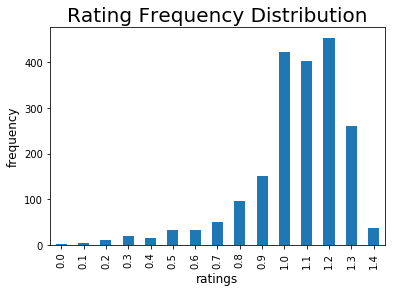

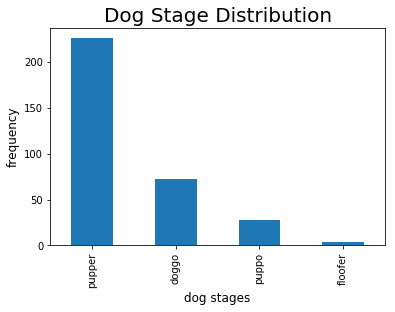

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,dog_name,Dog_stage,favorites,retweets,jpg_url,img_num,date,time,rating
21,887517139158093824,"<a href=""http://twitter.com/download/iphone"" r...",I've yet to rate a Venezuelan Hover Wiener. Th...,https://twitter.com/dog_rates/status/887517139...,14.0,10.0,,,45662,11509,https://pbs.twimg.com/ext_tw_video_thumb/88751...,1,07/19/2017,03:39,1.4
162,852226086759018497,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Meet General. He wasn't content with the quali...,https://twitter.com/dog_rates/status/852226086...,14.0,10.0,General,,20643,7158,https://pbs.twimg.com/ext_tw_video_thumb/85222...,1,04/12/2017,18:25,1.4
278,828381636999917570,"<a href=""http://twitter.com/download/iphone"" r...",Meet Doobert. He's a deaf doggo. Didn't stop h...,https://twitter.com/dog_rates/status/828381636...,14.0,10.0,Doobert,doggo,13413,2423,https://pbs.twimg.com/media/C38Asz1WEAAvzj3.jpg,1,02/05/2017,23:15,1.4
313,822462944365645825,"<a href=""http://twitter.com/download/iphone"" r...",This is Gabe. He was the unequivocal embodimen...,https://twitter.com/dog_rates/status/822462944...,14.0,10.0,Gabe,pupper,30429,16092,https://pbs.twimg.com/media/C2n5rUUXEAIXAtv.jpg,3,01/20/2017,15:17,1.4
131,860184849394610176,"<a href=""http://twitter.com/download/iphone"" r...",Here we have perhaps the wisest dog of all. Ab...,https://twitter.com/dog_rates/status/860184849...,14.0,10.0,,,16888,5975,https://pbs.twimg.com/media/C-_9jWWUwAAnwkd.jpg,1,05/04/2017,17:30,1.4


In [59]:
#create a master_df copy
analyze_df = master_df.copy()
#analyze_df.replace(' ', np.nan)

#plot frequency distribution of ratings
x = analyze_df['rating'].value_counts().sort_index()
x.plot(kind='bar')
plt.title ('Rating Frequency Distribution', fontsize=20)
plt.xlabel('ratings', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.show()

#plot distribution of dog stages
y = analyze_df[(analyze_df.Dog_stage == 'doggo') | (analyze_df.Dog_stage == 'floofer') | (analyze_df.Dog_stage == 'pupper') | (analyze_df.Dog_stage == 'puppo')]
y = y['Dog_stage'].value_counts()
y.plot(kind='bar')
plt.title ('Dog Stage Distribution', fontsize=20)
plt.xlabel('dog stages', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.show()

#find highest ranked dogs
highest_ranked = analyze_df.sort_values('rating',ascending=False)
highest_ranked.head()

## Insights

-  Mean rating for our dogs is 1.05 which translates to around 11/10
-  The most common rating is 1.2 followed by 1.0 and 1.1
-  Most of our dogs are in the pupper phase. Floofer dog is the least common
-  Highest ranked dogs are shown above all having a rating of 14/10 